### 마스크 착용 유무 분류 모델

- 사람의 얼굴 이미지를 입력했을 때 마스크 착용 유무를 분류해 주는 모델 탐색이 목표
- 약 6000장의 훈련 이미지셋을 활용해 마스크 착용 유무를 인식하는 모델
- 약 1000장의 검증 이미지셋으로 Accuracy 확인
- 직접 이미지를 입력해 예측 시도를 해 볼 수 있음

#### 데이터셋 출처

- https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset?resource=download

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os

In [ ]:
# 경로 설정
base_dir = '/content/drive/MyDrive/Colab Notebooks/MP/Face Mask Dataset'

train_dir = os.path.join(base_dir, 'Train/')
valid_dir = os.path.join(base_dir, 'Validation/')
test_dir = os.path.join(base_dir, 'Test/')

In [ ]:
# ImageDataGenerator 객체 생성 (이미지 학습 데이터 증폭을 위함)
datagen=ImageDataGenerator(rescale=1/255)

In [ ]:
# 이진분류 하기 위해 IDG 객체의 flow_from_directory 함수 사용
train=datagen.flow_from_directory(train_dir,class_mode='binary')
test=datagen.flow_from_directory(test_dir,class_mode='binary')

Found 5998 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [ ]:
# 이진분류를 어떻게 했는지 dictionary 형태로 확인
train.class_indices

{'WithMask': 0, 'WithoutMask': 1}

In [ ]:
input_shape=(256,256,3)

In [ ]:
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import RMSprop

model=Sequential()

model.add(Conv2D(64,(2,2),input_shape=input_shape,activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(BatchNormalization())

model.add(Conv2D(256,(2,2),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Conv2D(512,(2,2),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(BatchNormalization())

model.add(Dropout(0.3))


model.add(Dropout(0.4))


model.add(Flatten())


model.add(Dense(512,activation='relu'))
model.add(Dropout(0.4))


model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

early=EarlyStopping(monitor='accuracy',patience=3,mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=2, verbose=1,cooldown=0, mode='auto',min_delta=0.0001, min_lr=0)

In [ ]:
model.fit(train,epochs=20,validation_data=(test),shuffle=True,callbacks=[early,reduce_lr])

Epoch 1/20
188/188 [==============================] - 2775s 15s/step - loss: 0.3108 - accuracy: 0.9371 - val_loss: 0.1852 - val_accuracy: 0.9355 - lr: 0.0010
Epoch 2/20
188/188 [==============================] - 65s 346ms/step - loss: 0.0626 - accuracy: 0.9790 - val_loss: 0.0887 - val_accuracy: 0.9698 - lr: 0.0010
Epoch 3/20
188/188 [==============================] - 64s 342ms/step - loss: 0.0479 - accuracy: 0.9853 - val_loss: 0.1675 - val_accuracy: 0.9304 - lr: 0.0010
Epoch 4/20
188/188 [==============================] - 64s 341ms/step - loss: 0.0439 - accuracy: 0.9842 - val_loss: 0.1578 - val_accuracy: 0.9536 - lr: 0.0010
Epoch 5/20
188/188 [==============================] - 64s 341ms/step - loss: 0.0264 - accuracy: 0.9912 - val_loss: 0.2053 - val_accuracy: 0.9466 - lr: 0.0010
Epoch 6/20
188/188 [==============================] - 64s 339ms/step - loss: 0.0230 - accuracy: 0.9925 - val_loss: 0.1311 - val_accuracy: 0.9597 - lr: 0.0010
Epoch 7/20
188/188 [==============================] 

In [ ]:
model.save('/kaggle/working/mask_detection_model.h5')

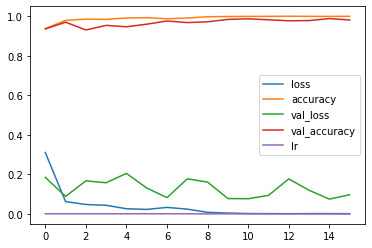

In [ ]:
import pandas as pd
loss=pd.DataFrame(model.history.history)
loss.plot()

Saving 화면 캡처 2022-10-20 155846.png to 화면 캡처 2022-10-20 155846.png
1/1 [==============================] - 0s 16ms/step
[[0.]]
마스크씀


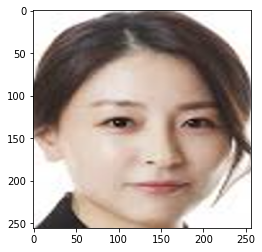

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras import utils
import matplotlib.pyplot as plt

uploaded=files.upload()

for fn in uploaded.keys():

  path='/content/' + fn
  img=utils.load_img(path, target_size=(256, 256))

  x=utils.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  print(classes)

  if classes[0]>0:
    print("마스크안씀")
  else:
    print("마스크씀")

    
  plt.imshow(img)

### 결론

- Accuracy는 검증 데이터셋으로 확인해 본 결과 약 90% 후반
- 사람의 '얼굴'이미지가 아니라 다른 신체부위도 보이는 이미지를 사용하면 분류에 오류가 잦음
- 사람의 얼굴만 보이는 이미지는 분류를 잘 수행하는 것을 확인